In [1]:
import os
import random
import matplotlib.pyplot as plt
import pylab
import numpy as np

In [2]:
import keras
from keras.models import Model
from keras import models
from keras.layers import *
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import TensorBoard
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
SEED = 145

Using TensorFlow backend.


# Load prepared data from folder
prepared from MADplot-AdvUNETS1-prepareData

In [3]:
x_train = np.load('excldCV5-data/HU_xTrain_All_images.npy')
y_train = np.load('excldCV5-data/HU_yTrain_All_images.npy')
x_val = np.load('excldCV5-data/HU_xVal_All_images.npy')
y_val = np.load('excldCV5-data/HU_yVal_All_images.npy')

In [4]:
print (x_train.shape)
print (y_train.shape)
#y_train.astype('float32')
print (x_val.shape)
print (y_val.shape)
#y_val.astype('float32')

(852, 512, 512, 2)
(852, 512, 512, 1)
(198, 512, 512, 2)
(198, 512, 512, 1)


In [5]:
count =  sum(sum(sum(y_train)))
total = 852*512*512
w2 = float(count/total)
w1 = 1-w2

weights = [w2, w1]
print(weights)

[0.06115531473652298, 0.938844685263477]


In [6]:
# Another sanity check
print (x_train[:,:,:,0].mean())
print (x_train[:,:,:,1].mean())
print (x_val[:,:,:,0].mean())
print (x_val[:,:,:,1].mean())

-532.317
-532.317
-556.53064
-556.53064


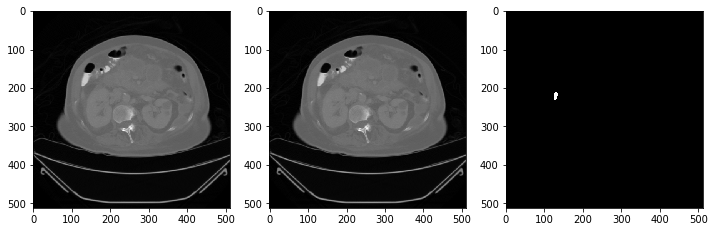

In [7]:
# Test a few data for sanity check
fig, ax = plt.subplots(1,3, figsize = (12,4))
ax[0].imshow(x_train[55,:,:,0].T, cmap='gray')
ax[1].imshow(x_train[55,:,:,1].T, cmap='gray')
ax[2].imshow(y_train[55,:,:,0].T, cmap='gray')
plt.show()

In [ ]:
# Code is here for initial training. Note that custom metrics is not compatible for saving and loading
#def dice_coef(y_true, y_pred):
#    y_true_f = K.flatten(y_true)
#    y_pred_f = K.flatten(y_pred)
#    intersection = K.sum(y_true_f * y_pred_f)
#    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

Create image generators for training and validation sets

In [8]:
def my_generator(x_data, y_data, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_data, x_data, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_data, y_data, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

In [9]:
train_gen = my_generator(x_train, y_train, 4)

In [10]:
val_gen = ImageDataGenerator().flow(x_val, y_val, batch_size=4, seed=SEED)

/home/yeeseng/anaconda3/envs/DLenv/lib/python3.6/site-packages/keras_preprocessing/image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (198, 512, 512, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


/home/yeeseng/anaconda3/envs/DLenv/lib/python3.6/site-packages/keras_preprocessing/image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (852, 512, 512, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


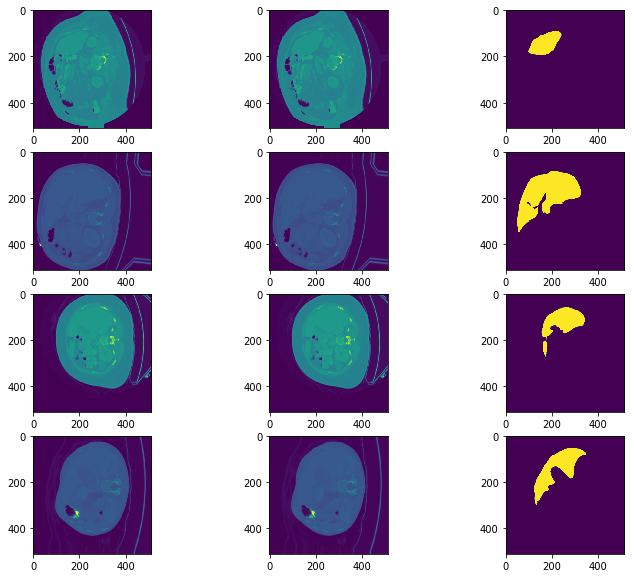

19138.456671714783

In [11]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 4))
fix, ax = plt.subplots(4,3, figsize=(12,10))
for i in range(4):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(image_batch[i,:,:,1])
    ax[i,2].imshow(mask_batch[i,:,:,0])
plt.show()

sum(sum(mask_batch[3,:,:,0]))

# UNET architecture

In [12]:
def unet(pretrained_weights = None,input_size = (512,512,2)):
    
    initializerString = 'TruncatedNormal'
    
    inputs = Input(input_size)
    norm1 = BatchNormalization(axis=-1)(inputs)
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(norm1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(conv4)
    drop4 = Dropout(0.3)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(conv5)
    drop5 = Dropout(0.3)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = -1)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = -1)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = -1)
    #merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = -1)
    #merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = initializerString)(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    
    model = Model(inputs = inputs, outputs = conv10)

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [13]:
model = unet(input_size = image_batch[1].shape)

In [14]:
model.compile(optimizer = Adam(lr=5e-7), loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 2)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 2)  8           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 1216        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

or if model is already saved, load model from h5 file

In [ ]:
#model = models.load_model('MADplot-AdvUNETS-Data/180805_MADplot-UNETS_19-0.997.h5')

In [16]:
from datetime import date
datestring = date.today().strftime("%y%m%d")

#weight_saver = ModelCheckpoint('MADplot-AdvUNETS-Data/' +datestring + '_MADplot-UNETS_{epoch:02d}-{val_binary_accuracy:.05f}.h5', monitor='binary_accuracy', save_best_only=True, save_weights_only=False)
#tensor_board = TensorBoard('./logs/'+datestring+'MADplot_AdvUNETS_simple1')
#annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [17]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
  display(Audio(url='http://www.kozco.com/tech/piano2.wav', autoplay=True))
## Insert whatever audio file you want above

allDone()

In [ ]:
#from sklearn.utils import class_weight

#k = [1, 0, 3, 2, 5, 0, 0, 0, 1]

#class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(k),
                                                 k)
#print(class_weights)
#model.fit(X_train, y_train, class_weight=class_weights)


In [ ]:
K.tensorflow_backend._get_available_gpus()
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [ ]:
sess = K.Session(config=tf.ConfigProto(log_device_placement=True))

In [18]:
import time
start = time.time()
print (start)

#class_weights = [0.022, 0.978]

hist = model.fit_generator(train_gen,
                           steps_per_epoch = 852*2,
                           validation_data = val_gen,
                           epochs=100,
                          callbacks = [],
                          validation_steps = int(198/4),
                          class_weight=weights)
    #savePath = 'MADplot-AdvUNETS-Data/liverSegUNETS_' + str(i+51) + '.h5'
    #model.save(savePath)

end = time.time()
print (end)
print(end - start)
    
allDone()

1553818894.4173584
Epoch 1/100
1704/1704 [==============================] - 939s 551ms/step - loss: 0.1700 - binary_accuracy: 0.9370 - val_loss: 0.0829 - val_binary_accuracy: 0.9625
Epoch 2/100
1704/1704 [==============================] - 935s 549ms/step - loss: 0.0844 - binary_accuracy: 0.9609 - val_loss: 0.0833 - val_binary_accuracy: 0.9633
Epoch 3/100
1704/1704 [==============================] - 936s 549ms/step - loss: 0.0673 - binary_accuracy: 0.9694 - val_loss: 0.0727 - val_binary_accuracy: 0.9675
Epoch 4/100
1704/1704 [==============================] - 936s 549ms/step - loss: 0.0593 - binary_accuracy: 0.9732 - val_loss: 0.0671 - val_binary_accuracy: 0.9695
Epoch 5/100
1704/1704 [==============================] - 936s 549ms/step - loss: 0.0541 - binary_accuracy: 0.9759 - val_loss: 0.0566 - val_binary_accuracy: 0.9752
Epoch 6/100
1704/1704 [==============================] - 936s 549ms/step - loss: 0.0499 - binary_accuracy: 0.9781 - val_loss: 0.0615 - val_binary_accuracy: 0.9739
Epo

KeyboardInterrupt: 

# Save model and history

In [ ]:
model.save('excldCV5-data/' + datestring + '_excldCV5-HU-800Epochs.h')

In [ ]:
testIdx = 72
testImage = x_val[testIdx:testIdx+1,:,:,:]

yhat = model.predict(testImage)

plt.imshow(x_val[testIdx,:,:,0].T)
plt.figure()
plt.imshow(yhat[0,:,:,0].T)
plt.figure()
plt.imshow(y_val[testIdx,:,:,0].T)

In [ ]:
for key in hist.history:
    print (key)

In [ ]:
bin_acc = hist.history['binary_accuracy']
val_bin_acc = hist.history['val_binary_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs =  range(1, len(bin_acc)+1)

plt.plot(epochs, bin_acc, 'bo', label='Training')
plt.plot(epochs, val_bin_acc, 'b', label='Validation')
plt.title('Training and validation binary accuracy')

plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
import pickle

datestring = date.today().strftime("%y%m%d")
filename = "excldCV5-data/" + datestring + "_HU_AdvUNETS_excldCV5_history.p"
outfile = open(filename, 'wb')

pickle.dump(hist.history, outfile)
outfile.close()

test pickle file

In [ ]:
outfile = open(filename, 'rb')
myhist = pickle.load(outfile)

In [ ]:
datGen = my_generator(x_val, y_val, 4)

for i in range(17):
    test_batch, test_mask_batch = next(datGen)

yhat = model.predict(test_batch)

fix, ax = plt.subplots(4,3, figsize=(12,25))
for i in range(4):
    ax[i,0].imshow(test_batch[i,:,:,0].T)
    ax[i,1].imshow(test_mask_batch[i,:,:,0].T)
    ax[i,2].imshow(yhat[i,:,:,0].T>0.5)
plt.show()